# Wstęp do multimediów (WMM)
### Kacper Górski, 331379


In [40]:
from matplotlib import pyplot as plt
from IPython.display import display, Markdown
import cv2
import numpy as np
import copy
from wlasciwosci_obrazow import printi, calc_entropy, dwt, calc_mse_psnr
import os

Image index to process:  35
image_col, wymiary: (480, 720, 3), typ danych: uint8, wartości: 12 - 255


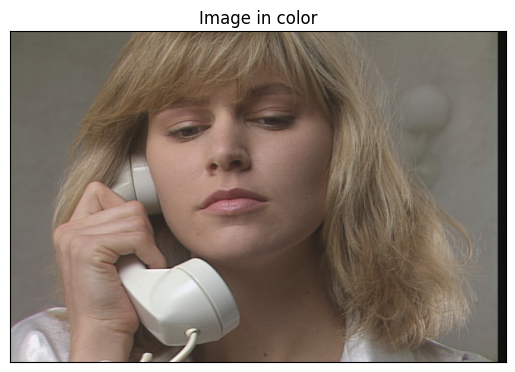

image, wymiary: (480, 720, 3), typ danych: uint8, wartości: 15 - 253


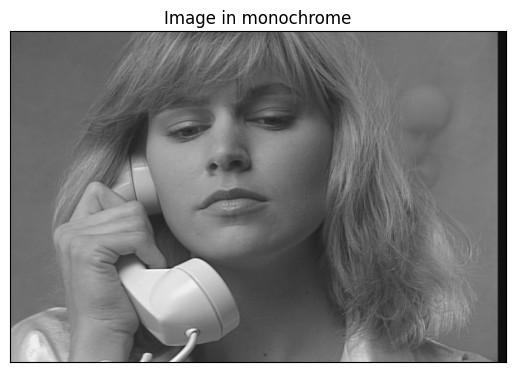

In [41]:
NUM_IMAGES = 36
STUDENT_INDEX = 331379

def image_to_process(student_index, num_images):
    return student_index % num_images

print("Image index to process: ", image_to_process(STUDENT_INDEX, NUM_IMAGES))

IMAGE_PATH_COL = os.path.join(os.getcwd(), "image", "susie_col.png")
IMAGE_PATH_MONO = os.path.join(os.getcwd(), "image", "susie_mono.png")

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plt_imshow(img, img_title="image", cmap = False):
    plt.figure()
    plt.title(img_title)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else: plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

image_col = load_image(IMAGE_PATH_COL)
printi(image_col, "image_col")
plt_imshow(image_col, "Image in color")

image_mono = load_image(IMAGE_PATH_MONO)
printi(image_mono, "image")
plt_imshow(image_mono, "Image in monochrome")

### Obraz do przetworzenia -> susie_col.png (index: 35)

## Dla obrazu monochromatycznego: 

- Obliczyć entropię obrazu wejściowego.   

In [42]:
def scale_for_display(img, is_dwt=False):
    """Normalizacja obrazu do wyświetlania"""
    if is_dwt:
        img_abs = np.abs(img)
        return cv2.normalize(img_abs, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

hist_mono = cv2.calcHist([image_mono], [0], None, [256], [0, 256]).flatten()
mono_entropy = calc_entropy(hist_mono)
print("Entropia obrazu monochromatycznego: ", mono_entropy)

Entropia obrazu monochromatycznego:  7.0009653878587415


- Wyznaczyć obraz różnicowy w taki sposób, że wartość każdego piksela zastępowana jest różnicą 
pomiędzy wartością tego piksela a wartością jego lewego sąsiada (kodowanie różnicowe /. 
predykcyjne). Dla pierwszego piksela w linii należy przyjąć wartość sąsiada równą 127 (środkowa 
wartość przedziału zmienności wartości pikseli).     
Wyświetlić obraz różnicowy.     
Wyznaczyć histogram obrazu różnicowego i porównać go z histogramem obrazu oryginalnego.   
Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.   
Uwaga: należy pamiętać, że wartości pikseli w obrazie różnicowym są z zakresu [-255; 255]!   

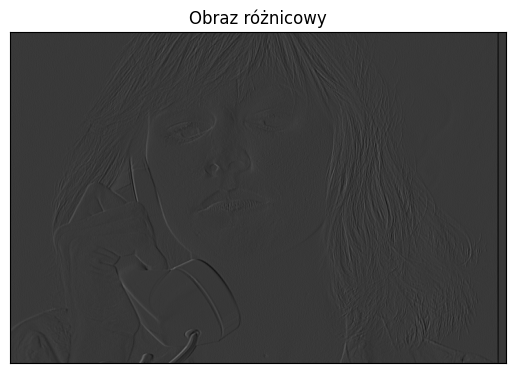

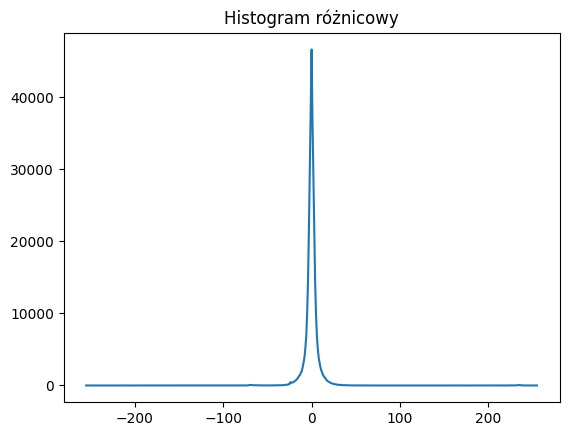

Entropia różnicowa: 4.4032 bits/piksel


In [43]:
def create_diff_image(img):
    PIXEL_VALUE = 127

    diff = np.zeros_like(img, dtype=np.int16)
    diff[:,0] = img[:,0] - PIXEL_VALUE
    diff[:,1:] = img[:,1:].astype(np.int16) - img[:,:-1].astype(np.int16)
    return diff

image_diff = create_diff_image(image_mono)

plt_imshow(scale_for_display(image_diff), "Obraz różnicowy", "gray")

hist_diff = cv2.calcHist([image_diff.astype(np.float32)], [0], None, [511], [-255, 256]).flatten()
plt.figure()
plt.plot(np.linspace(-255, 255, 511), hist_diff)
plt.title("Histogram różnicowy")
plt.show()

diff_entropy = calc_entropy(hist_diff)
print(f"Entropia różnicowa: {diff_entropy:.4f} bits/piksel")

- Wyznaczyć współczynniki DWT korzystając z funkcji zamieszczonej w przykładowym skrypcie.  
Wyświetlić poszczególne pasma.   
Wyznaczyć histogramy i obliczyć entropię dla wszystkich pasm.   
Porównać wyniki (histogram, entropia) uzyskane dla poszczególnych pasm między sobą (czy któreś 
się wyróżniają i dlaczego?) oraz z wynikami uzyskanymi dla obrazu oryginalnego i obrazu 
różnicowego.    
Uwaga: należy pamiętać, że wartości w pasmach LH, HL i HH są z zakresu [-255, 255]!    

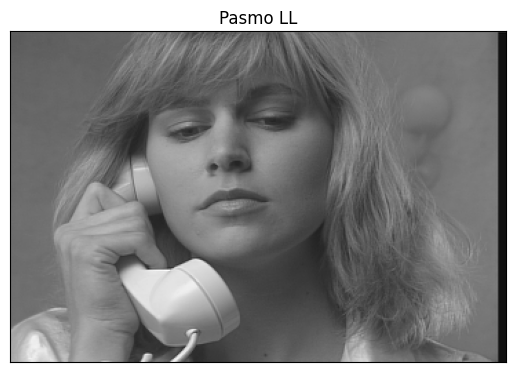

band_LL, wymiary: (240, 360, 3), typ danych: uint8, wartości: 7 - 255


**Entropia pasma LL:** 6.9940

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-66..125].


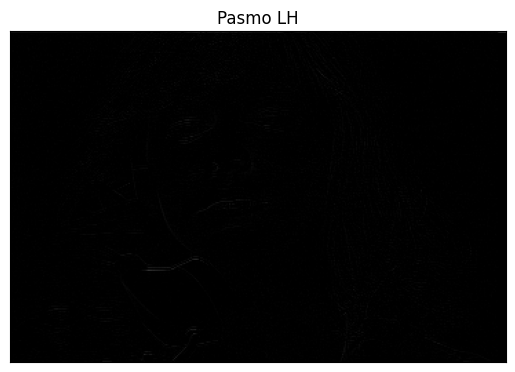

band_LH, wymiary: (240, 360, 3), typ danych: int16, wartości: -66 - 125


**Entropia pasma LH:** 3.4145

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-41..45].


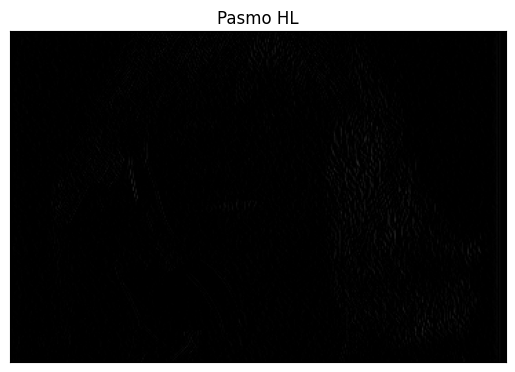

band_HL, wymiary: (240, 360, 3), typ danych: int16, wartości: -41 - 45


**Entropia pasma HL:** 3.7946

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-29..34].


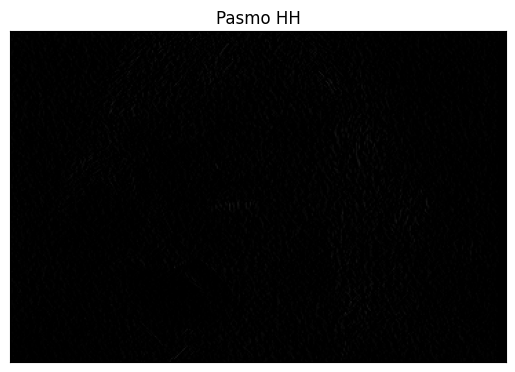

band_HH, wymiary: (240, 360, 3), typ danych: int16, wartości: -29 - 34


**Entropia pasma HH:** 4.0544

In [44]:
bands = dwt(image_mono)
band_names = ["LL", "LH", "HL", "HH"]
entropies = []

def compute_band_entropy(band, num_bins=256, shift=0):
    band_shifted = (band + shift).astype(np.uint16)
    hist = cv2.calcHist([band_shifted], [0], None, [num_bins], [0, num_bins]).flatten()
    return hist, calc_entropy(hist)

for band, band_name in zip(bands, band_names):

    plt_imshow(band, "Pasmo " + band_name, cmap="gray")
    printi(band, "band_" + band_name)

    num_bins = 256 if band_name == "LL" else 511
    shift = 0 if band_name == "LL" else 255
    band_hist, band_entropy = compute_band_entropy(band, num_bins=num_bins, shift=shift)
    display(Markdown(f"**Entropia pasma {band_name}:** {band_entropy:.4f}"))

    entropies.append(band_entropy)

- Obliczyć przepływność (liczbę bitów przypadającą na jeden piksel) dla obrazu skompresowanego 
koderem PNG (obraz wejściowy) i porównać ją z obliczonymi uprzednio entropiami obrazu 
oryginalnego, różnicowego i falokowego. Czy przepływność mniejsza od entropii oznacza, że 
zależność: lśr ≥ H jest nieprawdziwa?

In [45]:
def calc_bitrate(img, size):
    return (size * 8) / (img.shape[0] * img.shape[1])

def calc_png_size(img_path):
    return os.path.getsize(img_path)

png_size = calc_png_size(IMAGE_PATH_MONO)
png_bitrate = calc_bitrate(image_mono, png_size)

print(f"Rozmiar PNG: {png_size} bajtów")
print(f"Bitrate PNG: {png_bitrate:.4f} bpp")

print(f"Oryginał: {mono_entropy:.2f} | Różnicowy: {diff_entropy:.2f} | DWT średnia: {np.mean(entropies):.2f}")

Rozmiar PNG: 192017 bajtów
Bitrate PNG: 4.4448 bpp
Oryginał: 7.00 | Różnicowy: 4.40 | DWT średnia: 4.56


## Dla obrazu barwnego:

- Obliczyć entropię dla składowych RGB barwnego obrazu testowego.

In [46]:
entropies_rgb = []
for i, channel in enumerate(['R', 'G', 'B']):
    hist = cv2.calcHist([image_col[:,:,i]], [0], None, [256], [0, 256])
    entropies_rgb.append(calc_entropy(hist))

    print(f"Entropia {channel}: {float(entropies_rgb[-1]):.4f}")

Entropia R: 7.0322
Entropia G: 7.0014
Entropia B: 7.0370


C:\Users\Kacper\AppData\Local\Temp\ipykernel_5276\2614010749.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Entropia {channel}: {float(entropies_rgb[-1]):.4f}")


- Dokonać konwersji z RGB do YUV i obliczyć entropię dla składowych YUV. Wyświetlić składowe 
RGB i YUV.  
Wyznaczyć histogramy dla wszystkich składowych RGB i YUV.   
Porównać wyniki uzyskane dla poszczególnych składowych. Czy dla składowych UV entropia jest 
mniejsza? Z czego ta mniejsza wartość może wynikać? 

In [47]:
image_col_yuv = cv2.cvtColor(image_col, cv2.COLOR_RGB2YUV)
entropies_yuv = []

for i, channel in enumerate(['Y', 'U', 'V']):
    hist = cv2.calcHist([image_col_yuv[:,:,i]], [0], None, [256], [0, 256])
    entropies_yuv.append(calc_entropy(hist))

    print(f"Entropia {channel}: {float(entropies_yuv[-1]):.4f}")

Entropia Y: 6.9753
Entropia U: 3.8968
Entropia V: 4.3195


C:\Users\Kacper\AppData\Local\Temp\ipykernel_5276\741920858.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Entropia {channel}: {float(entropies_yuv[-1]):.4f}")


- Wyznaczyć zależność zniekształcenia D od przepływności R (liczba bitów przypadającą na jeden 
piksel obrazu): D = f(R) – tzw. krzywa R-D – dla kodera JPEG.   
Regulacji stopnia kompresji (przepływności R) należy dokonywać ustawiając wartości parametru 
‘quality’ przy zapisie obrazu do pliku. Wartości parametru ‘quality’ należy dobrać tak, aby uzyskać 
‘gładkie’ wykresy.   
Jako miarę zniekształceń należy użyć szczytowy stosunek sygnału do szumu PSNR i błąd 
średniokwadratowy MSE.   
Zobrazować zależności na wykresach (oddzielny wykres dla każdej miary).   
Dokonać subiektywnej oceny obrazów zrekonstruowanych (według własnej skali ocen, np.: jakość 
doskonała, bardzo dobra, dobra, średnia, kiepska, zła, bardzo zła, itp., lub: zniekształcenia 
niewidoczne, lekko widoczne, widoczne, bardzo widoczne, nie do przyjęcia, itp.) i zamieścić te oceny 
w sprawozdaniu (niekoniecznie dla każdego obrazu wynikowego osobno, raczej ‘zgrupować’ oceny 
dla pewnych zakresów przepływności).   
Porównać stopnie kompresji uzyskiwane dla kodera JPEG ze stopniem kompresji uzyskanym dla 
kodera PNG (pamiętając, że w pierwszej części laboratorium wykorzystywany był 
monochromatyczny obraz PNG, a kompresja JPEG była wykonywana dla obrazu barwnego; 
ewentualnie obliczyć przepływność bitową dla obrazu barwnego skompresowanego koderem PNG).

Jakość: 100 | Rozmiar: 245599 bajtów | MSE: 657.65 | PSNR: 19.95 dB | Bitrate: 5.6852 bpp


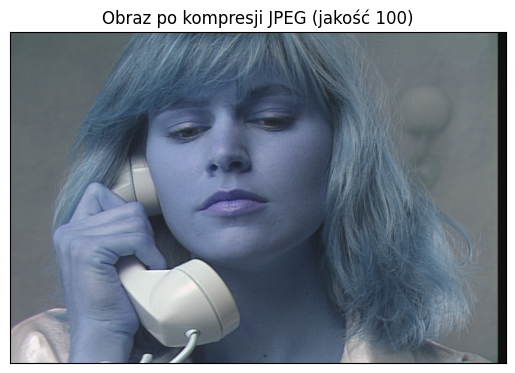

Jakość: 90 | Rozmiar: 65359 bajtów | MSE: 659.88 | PSNR: 19.94 dB | Bitrate: 1.5129 bpp


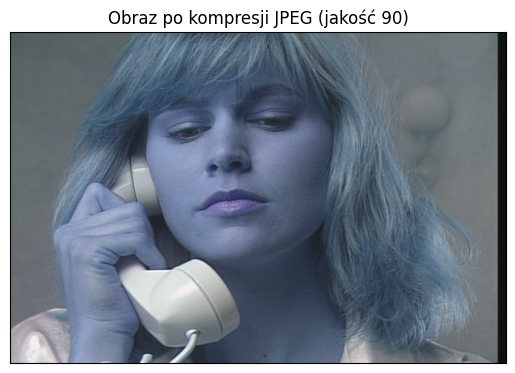

Jakość: 80 | Rozmiar: 41098 bajtów | MSE: 660.87 | PSNR: 19.93 dB | Bitrate: 0.9513 bpp


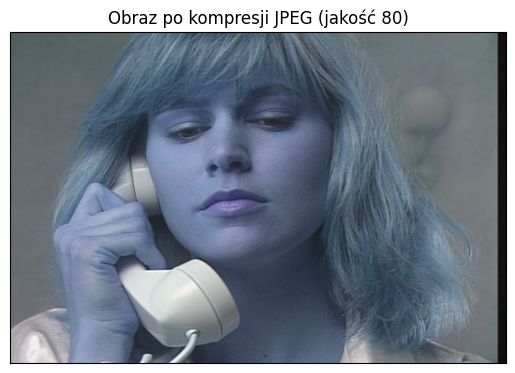

Jakość: 70 | Rozmiar: 31555 bajtów | MSE: 665.55 | PSNR: 19.90 dB | Bitrate: 0.7304 bpp


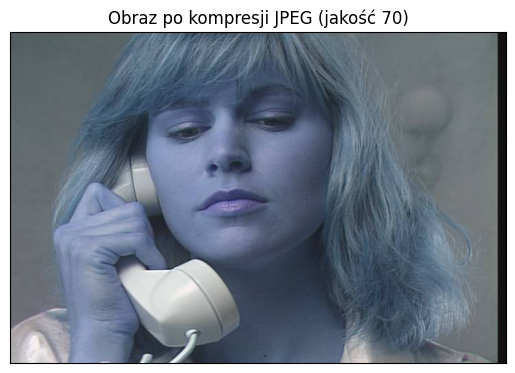

Jakość: 60 | Rozmiar: 26138 bajtów | MSE: 666.36 | PSNR: 19.89 dB | Bitrate: 0.6050 bpp


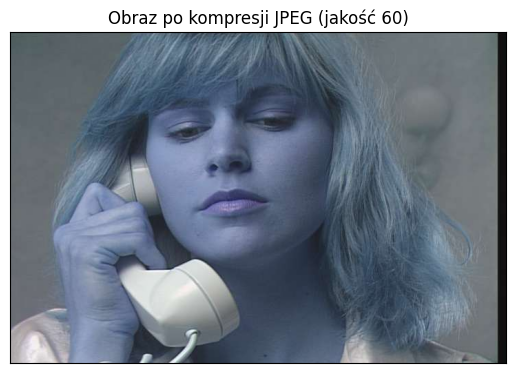

Jakość: 50 | Rozmiar: 22701 bajtów | MSE: 664.57 | PSNR: 19.91 dB | Bitrate: 0.5255 bpp


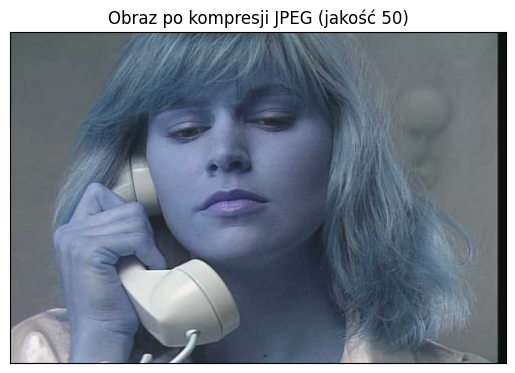

Jakość: 40 | Rozmiar: 19635 bajtów | MSE: 661.36 | PSNR: 19.93 dB | Bitrate: 0.4545 bpp


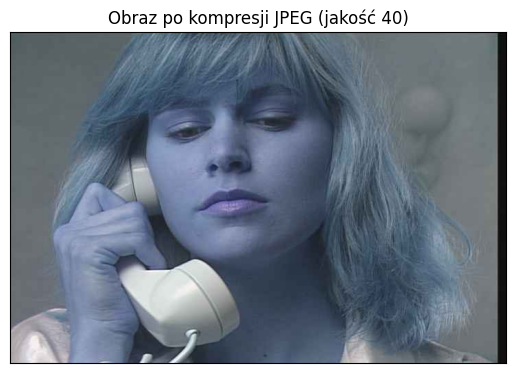

Jakość: 30 | Rozmiar: 16674 bajtów | MSE: 672.51 | PSNR: 19.85 dB | Bitrate: 0.3860 bpp


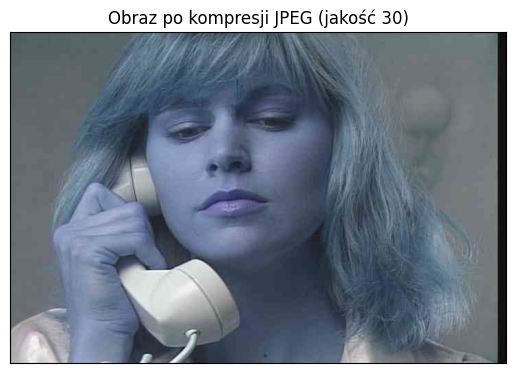

Jakość: 20 | Rozmiar: 13106 bajtów | MSE: 673.52 | PSNR: 19.85 dB | Bitrate: 0.3034 bpp


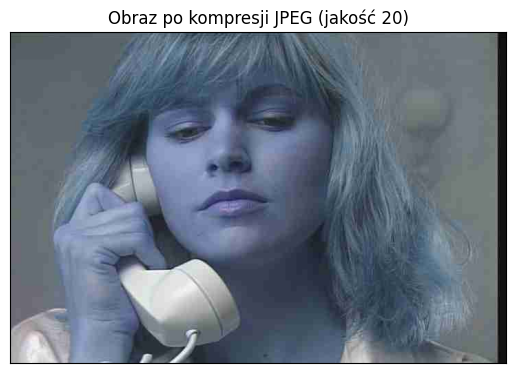

Jakość: 10 | Rozmiar: 9210 bajtów | MSE: 699.91 | PSNR: 19.68 dB | Bitrate: 0.2132 bpp


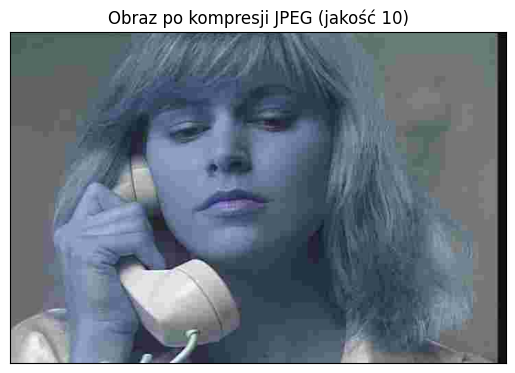

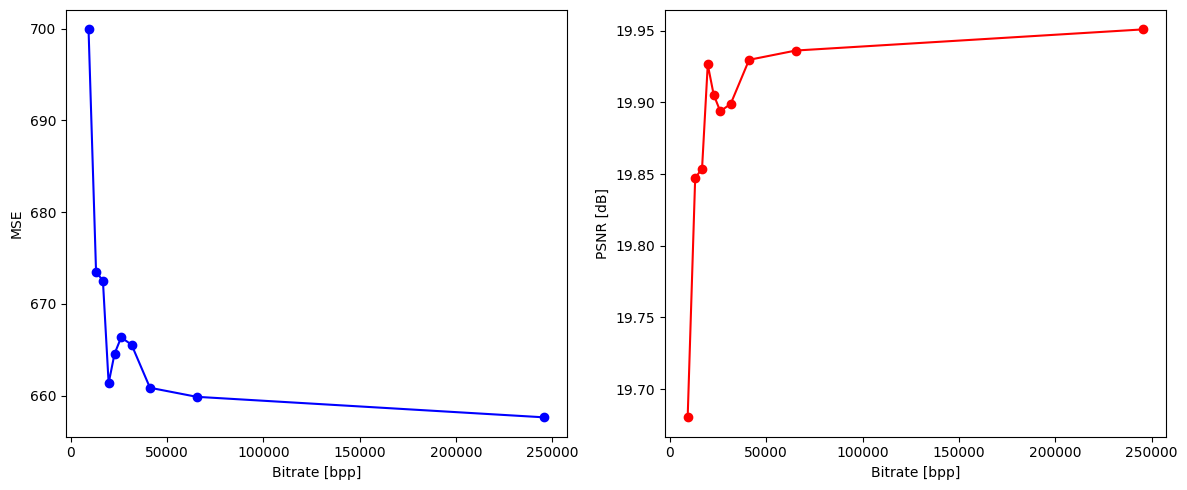


Bitrate PNG (kolor): 12.14 bpp


In [ ]:
qualities = np.arange(100, 0, -10)
results = []

TEMP_IMG_PATH = os.path.join(os.getcwd(), "image", "temp.jpg")

for quality in qualities:
    cv2.imwrite(TEMP_IMG_PATH, cv2.cvtColor(image_col, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), quality])

    size = os.path.getsize(TEMP_IMG_PATH)
    compressed = cv2.cvtColor(cv2.imread(TEMP_IMG_PATH), cv2.COLOR_BGR2RGB)

    mse, psnr = calc_mse_psnr(image_col, compressed)
    bitrate = calc_bitrate(image_col, size)

    results.append((quality, size, mse, psnr, bitrate))

    print(f"Jakość: {quality} | Rozmiar: {size} bajtów | MSE: {mse:.2f} | PSNR: {psnr:.2f} dB | Bitrate: {bitrate:.4f} bpp")
    plt_imshow(compressed, f"Obraz po kompresji JPEG (jakość {quality})", cmap="gray")

    os.remove(TEMP_IMG_PATH)

results = np.array(results)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(results[:,1], results[:,2], 'b-o')
plt.xlabel('Bitrate [bpp]'), plt.ylabel('MSE')
plt.subplot(122)
plt.plot(results[:,1], results[:,3], 'r-o')
plt.xlabel('Bitrate [bpp]'), plt.ylabel('PSNR [dB]')
plt.tight_layout()
plt.show()

# porównanie z PNG
png_size_col = os.path.getsize(IMAGE_PATH_COL)
bitrate_png = (png_size_col * 8) / (image_col.size//3)
print(f"\nBitrate PNG (kolor): {bitrate_png:.2f} bpp")